In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2006 统计分析

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_06(log_A,log_f_b,alpha_H,log_poisson):
    alpha_L = 1.0
    
    perdata06 = pd.read_csv("perlist06_h.csv")
    f = perdata06['f']
    per = perdata06['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
     
    
    length = len(perdata06)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m06=Minuit(twi_minus_loglikelihood_06,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,log_poisson=0.0,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_log_poisson=0.1,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_log_poisson=(0,3),
         errordef=1)

m06.migrad()

pprint(m06.fval)

FCN = -1236.9677578079807 
 TOTAL NCALL = 159 
 NCALLS = 159 
 
 
 EDM = 1.989476009735364e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-2.29215,0.158339,,,-3,-1,No
1,log_f_b,-3.86704,0.136486,,,-5,-2,No
2,alpha_H,3.3068,0.348349,,,1,5,No
3,poisson,0.168015,0.00554297,,,0,2,No


-1236.9677578079807


In [4]:
perdata06 = pd.read_csv("perlist06_h.csv")
f_06 = perdata06['f']
per_06 = perdata06['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,log_poisson = m06.values[0],m06.values[1],m06.values[2],m06.values[3]

model_06 = []
R_obs_06 = []
T_SSE_obs_06 = 0
f_length_06 = len(f_06)
for i in range(f_length_06):
    model_06.append(((f_06[i]**(-alpha_L))/(1+(f_06[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
    R_obs_06.append(2*per_06[i]/model_06[i])
    T_SSE_obs_06 += (((per_06[i]-model_06[i])/model_06[i])**2)
    
# 两个统计量
T_R_obs_06 = max(R_obs_06)
print ("T_R =", T_R_obs_06)
print ("T_SSE =", T_SSE_obs_06)

T_R = 13.695484867237228
T_SSE = 1073.8175500319135


In [5]:
# 5000条光变曲线

df = 0.01/f_length_06
N = 2*f_length_06
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_06]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_06):
        R_simu.append(2*per_simu[i]/model_06[i])
        T_SSE_simu += (((per_simu[i]-model_06[i])/model_06[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_06:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_06:
        n_TSSE += 1

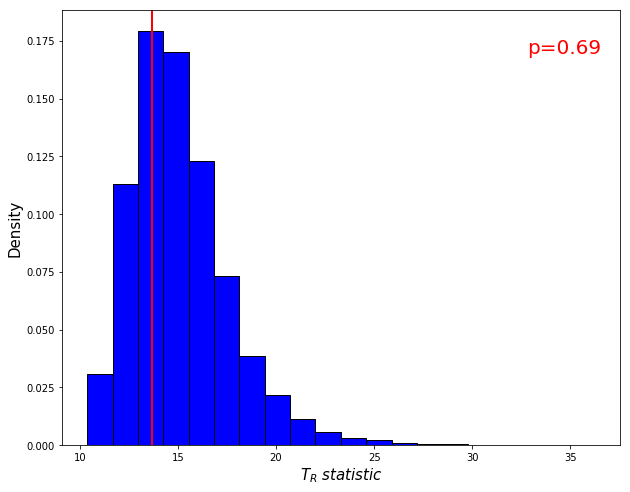

In [6]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_06, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

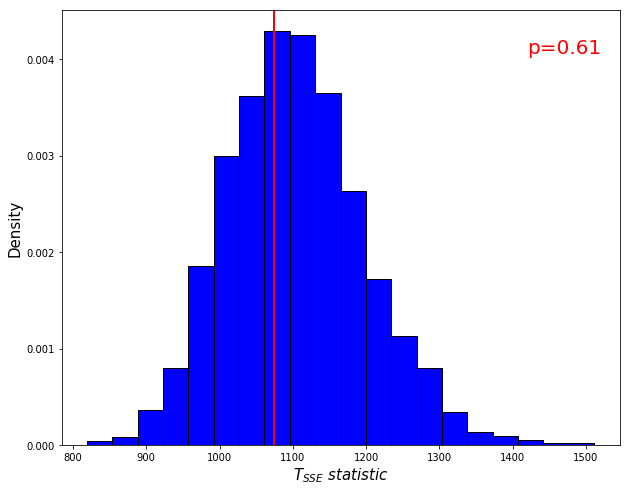

In [7]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_06, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2009(1) 统计分析

In [8]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_091(log_A,log_f_b,alpha_H,log_poisson):
    alpha_L = 1.0
    
    perdata091 = pd.read_csv("perlist091_h.csv")
    f = perdata091['f']
    per = perdata091['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
     
    
    length = len(perdata091)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [9]:
m091=Minuit(twi_minus_loglikelihood_091,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,log_poisson=0.0,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_log_poisson=0.1,
         limit_log_A=(-3,-1), limit_log_f_b=(-6,-2),limit_alpha_H=(1.0,5.0),limit_log_poisson=(0,3),
         errordef=1)

m091.migrad()

pprint(m091.fval)

FCN = 3227.1304151883483 
 TOTAL NCALL = 284 
 NCALLS = 284 
 
 
 EDM = 1.974205590084926e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.14163,0.383623,,,-3,-1,No
1,log_f_b,-4.65901,0.406627,,,-6,-2,No
2,alpha_H,2.57255,0.273953,,,1,5,No
3,poisson,1.62531,0.0551025,,,0,15,No


3227.1304151883483


In [10]:
perdata091 = pd.read_csv("perlist091_h.csv")
f_091 = perdata091['f']
per_091 = perdata091['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,log_poisson = m091.values[0],m091.values[1],m091.values[2],m091.values[3]

model_091 = []
R_obs_091 = []
T_SSE_obs_091 = 0
f_length_091 = len(f_091)
for i in range(f_length_091):
    model_091.append(((f_091[i]**(-alpha_L))/(1+(f_091[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
    R_obs_091.append(2*per_091[i]/model_091[i])
    T_SSE_obs_091 += (((per_091[i]-model_091[i])/model_091[i])**2)
    
# 两个统计量
T_R_obs_091 = max(R_obs_091)
print ("T_R =", T_R_obs_091)
print ("T_SSE =", T_SSE_obs_091)

T_R = 18.175589125275483
T_SSE = 1107.6046051560836


In [11]:
# 5000条光变曲线

df = 0.01/f_length_091
N = 2*f_length_091
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_091]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_091):
        R_simu.append(2*per_simu[i]/model_091[i])
        T_SSE_simu += (((per_simu[i]-model_091[i])/model_091[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_091:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_091:
        n_TSSE += 1

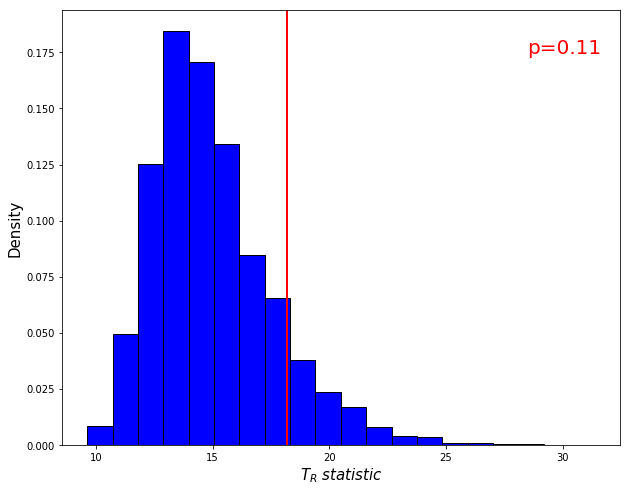

In [12]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_091, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

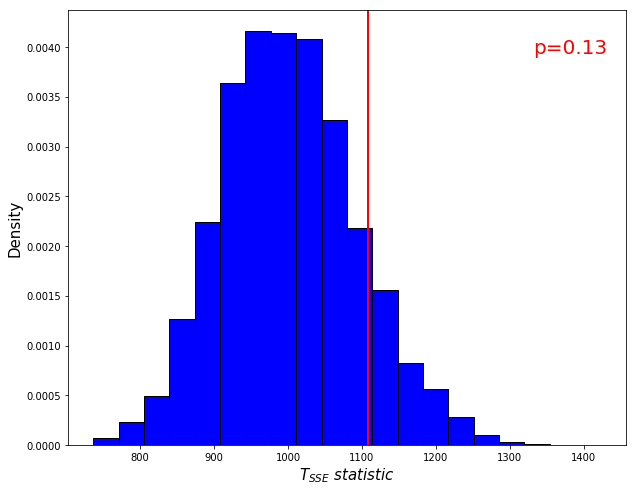

In [13]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_091, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2009(2) 统计分析

In [14]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_092(log_A,log_f_b,alpha_H,log_poisson):
    alpha_L = 1.0
    
    perdata092 = pd.read_csv("perlist092_h.csv")
    f = perdata092['f']
    per = perdata092['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
     
    
    length = len(perdata092)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [15]:
m092=Minuit(twi_minus_loglikelihood_092,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,log_poisson=0.0,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_log_poisson=0.1,
         limit_log_A=(-3,0), limit_log_f_b=(-8,-2),limit_alpha_H=(1.0,5.0),limit_log_poisson=(0,3),
         errordef=1)

m092.migrad()

pprint(m092.fval)

FCN = 2866.814680072467 
 TOTAL NCALL = 485 
 NCALLS = 485 
 
 
 EDM = 1.2374386978136725e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.14123,0.540303,,,-3,0,No
1,log_f_b,-4.59535,0.466385,,,-8,-2,No
2,alpha_H,2.82848,0.410763,,,1,5,No
3,poisson,1.96454,0.0726113,,,0,15,No


2866.814680072467


In [16]:
perdata092 = pd.read_csv("perlist092_h.csv")
f_092 = perdata092['f']
per_092 = perdata092['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,log_poisson = m092.values[0],m092.values[1],m092.values[2],m092.values[3]

model_092 = []
R_obs_092 = []
T_SSE_obs_092 = 0
f_length_092 = len(f_092)
for i in range(f_length_092):
    model_092.append(((f_092[i]**(-alpha_L))/(1+(f_092[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
    R_obs_092.append(2*per_092[i]/model_092[i])
    T_SSE_obs_092 += (((per_092[i]-model_092[i])/model_092[i])**2)
    
# 两个统计量
T_R_obs_092 = max(R_obs_092)
print ("T_R =", T_R_obs_092)
print ("T_SSE =", T_SSE_obs_092)

T_R = 18.46308405054842
T_SSE = 875.8268570568063


In [17]:
# 5000条光变曲线

df = 0.01/f_length_092
N = 2*f_length_092
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_092]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_092):
        R_simu.append(2*per_simu[i]/model_092[i])
        T_SSE_simu += (((per_simu[i]-model_092[i])/model_092[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_092:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_092:
        n_TSSE += 1

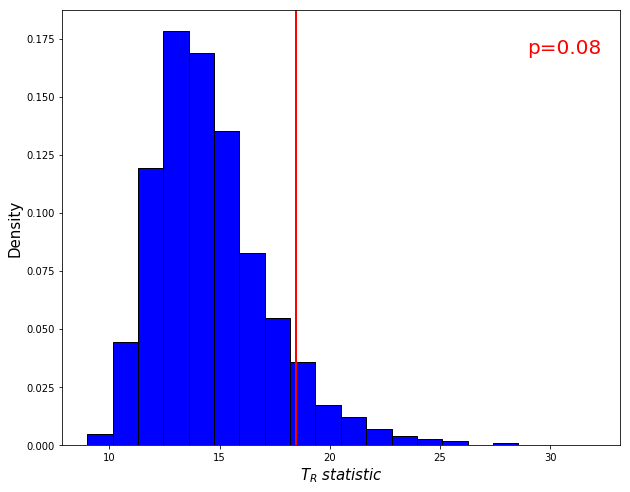

In [18]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_092, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

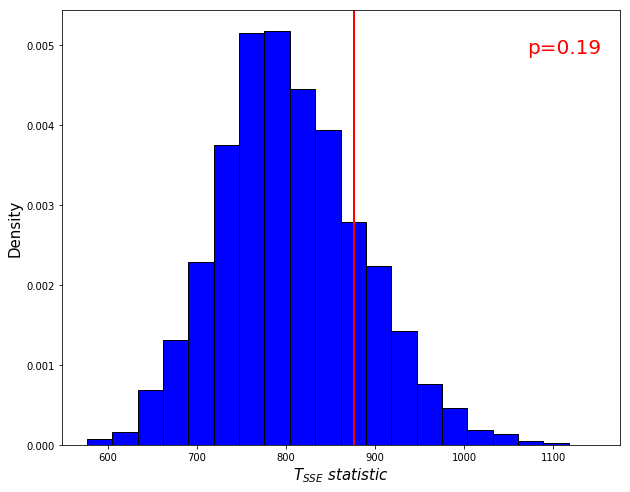

In [19]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_092, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()